# 1. Overview

# 2. Data Understanding

## 2.1 Data Description

## 2.2 Import necessary libraries

In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt 
import numpy as np

from datetime import datetime

## 2.3 Define Global Variables

In [2]:
company_name = 'ASML'  # Replace 'ASML' with any other company ticker (e.g., 'AAPL' for Apple)
start_date = '2000-01-01'
end_date = datetime.today().strftime("%Y-%m-%d")

## 2.4 Functions

In [3]:
def get_historical_data(ticker_symbol, start_date, end_date):
    """
    Fetches historical stock data for a given company between specified dates. 
    Returns a DataFrame containing the historical data.

    Input:
    - ticker_symbol: The stock ticker of the company (e.g., 'ASML').
    - start_date: The start date for the historical data (e.g., '2000-01-01').
    - end_date: The end date for the historical data (e.g., '2024-10-05').

    Output:
    - A pandas DataFrame containing the historical stock data for the specified period.
    """
    # Define the ticker symbol
    stock_data = yf.Ticker(ticker_symbol)

    # Download historical data between the start and end dates
    historical_data = stock_data.history(start=start_date, end=end_date)

    # Reset the index to convert 'Date' from an index to a regular column
    historical_data.reset_index(inplace=True)

    # Return the resulting DataFrame
    return historical_data

In [4]:
def plot_closing_prices(historical_data, company_name):
    """
    Plots the historical closing prices of a company's stock over time.

    Input:
    - historical_data: DataFrame containing the stock data with 'Date' and 'Close' columns.
    - company_name: The name or ticker of the company to be displayed in the plot title.

    Output:
    - A line plot of the company's historical closing prices.
    """
    # Convert the 'Date' and 'Close' columns to numpy arrays
    dates = np.array(historical_data['Date'])
    close_prices = np.array(historical_data['Close'])

    # Create the plot for the 'Close' (closing price) column using matplotlib
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.plot(dates, close_prices, label='Closing Price', color='blue')

    # Add title and axis labels
    plt.title(f'Historical Closing Prices of {company_name} between {dates[0].date()} and {dates[-1].date()}')
    plt.xlabel('Date')
    plt.ylabel('Closing Price (USD)')

    # Rotate X-axis labels for better readability
    plt.xticks(rotation=45)

    # Show the legend
    plt.legend()

    # Adjust layout to prevent overlap of elements
    plt.tight_layout()

    # Display the plot
    plt.show()

## 2.5 Code

We are going to load the data using the function get_historical_data

In [7]:
# Call the function get_historical_data
historical_data = get_historical_data(company_name, start_date, end_date)

historical_data 

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2000-01-03 00:00:00-05:00,27.080377,27.080377,25.865232,26.935717,1121600,0.0,0.0
1,2000-01-04 00:00:00-05:00,25.894166,26.270283,25.055137,25.141933,968800,0.0,0.0
2,2000-01-05 00:00:00-05:00,24.245043,24.505431,23.304752,24.447567,1458133,0.0,0.0
3,2000-01-06 00:00:00-05:00,22.682710,23.203486,21.742419,22.943098,3517867,0.0,0.0
4,2000-01-07 00:00:00-05:00,22.755042,23.492809,22.624848,23.463877,1631200,0.0,0.0
...,...,...,...,...,...,...,...,...
6226,2024-10-02 00:00:00-04:00,820.799988,839.270020,816.500000,832.190002,898400,0.0,0.0
6227,2024-10-03 00:00:00-04:00,825.909973,837.510010,823.789978,832.409973,651900,0.0,0.0
6228,2024-10-04 00:00:00-04:00,836.049988,839.340027,825.960022,833.000000,862500,0.0,0.0
6229,2024-10-07 00:00:00-04:00,811.719971,823.000000,811.010010,817.250000,898200,0.0,0.0


Now let's plot the stock data

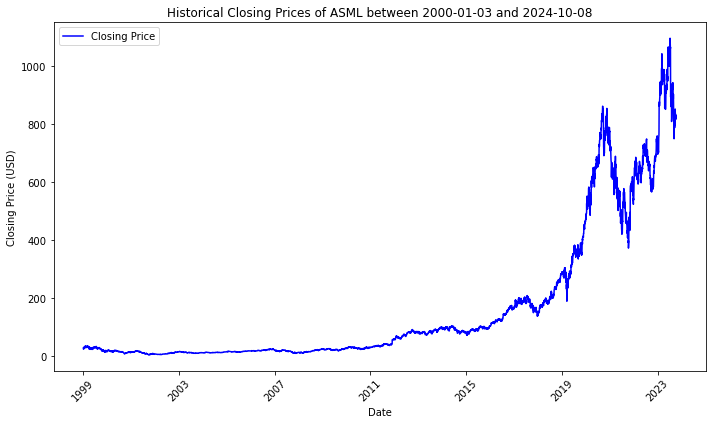

In [8]:
plot_closing_prices(historical_data, company_name)